In [1]:
### Bora Yildiz - Gambling Addiction & Psychology - DSA210 Project ###

# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

#Grid style for datasets
sns.set(style="whitegrid")

In [2]:
# Loading datasets from datas/ folder
icspr = pd.read_csv("datas/ICSPR Gambling Behavioural Study.tsv", sep="\t")
kaggle_gambling = pd.read_csv("datas/Kaggle Gambling Data.csv")
bigfive = pd.read_csv("datas/Kaggle Big Five Personalities.csv", sep="\t")
fed_debt = pd.read_excel("datas/Federal Reserve Consumer Debt Reports.xlsx", sheet_name=None)

In [3]:
#Dataset Cleaning

# --- ICSPR Dataset ---
# Created a new column 'problem_gambler' based on DSM-IV diagnostic criteria
# EVERPROB = number of problem gambling symptoms a respondent answered "yes" to
# DSM-IV clinical psycholog claims that 5 or more symptoms qualifies as "pathological gambling"
# For pathological gambling everprob value must be >= 5
icspr['problem_gambler'] = icspr['EVERPROB'] >= 5

# --- Big Five Personality Dataset ---
# Define the grouping of Big Five traits based on their survey questions
# EXT = Extraversion, EST = Neuroticism, AGR = Agreeableness, CSN = Conscientiousness, OPN = Openness (From Codebook,.txt is on github)
traits = {
    'extraversion': [f'EXT{i}' for i in range(1, 11)],
    'neuroticism': [f'EST{i}' for i in range(1, 11)],
    'agreeableness': [f'AGR{i}' for i in range(1, 11)],
    'conscientiousness': [f'CSN{i}' for i in range(1, 11)],
    'openness': [f'OPN{i}' for i in range(1, 11)],
}
# Calculate the average score for each Big Five trait per participant
# This creates a single representative value for each trait (instead of 10 questions separately)
for trait, columns in traits.items():
    if all(col in bigfive.columns for col in columns):
        bigfive[trait] = bigfive[columns].mean(axis=1)

# --- Federal Reserve Debt Dataset ---
# Get the name of the first sheet, uploaded Excel file had multiple sheets
fed_sheet_name = list(fed_debt.keys())[0]
fed_df = fed_debt[fed_sheet_name]

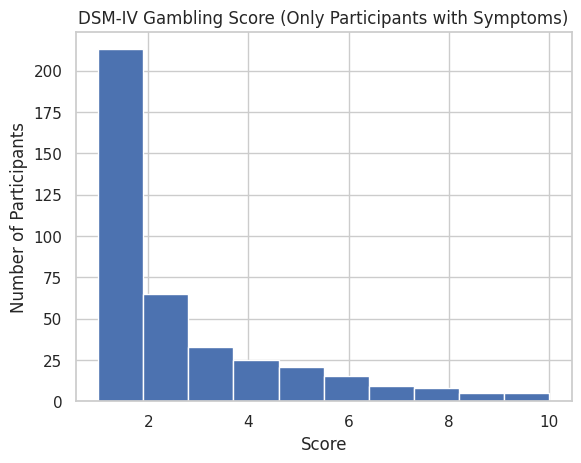

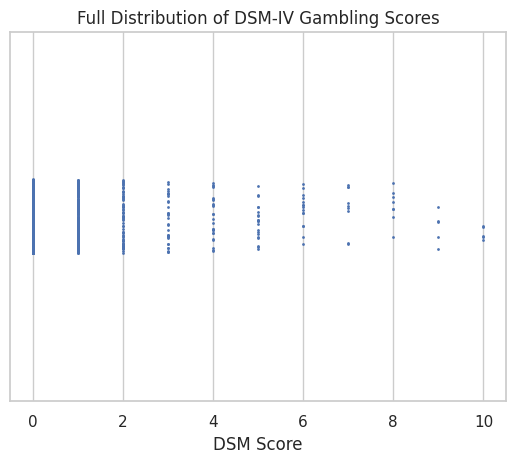

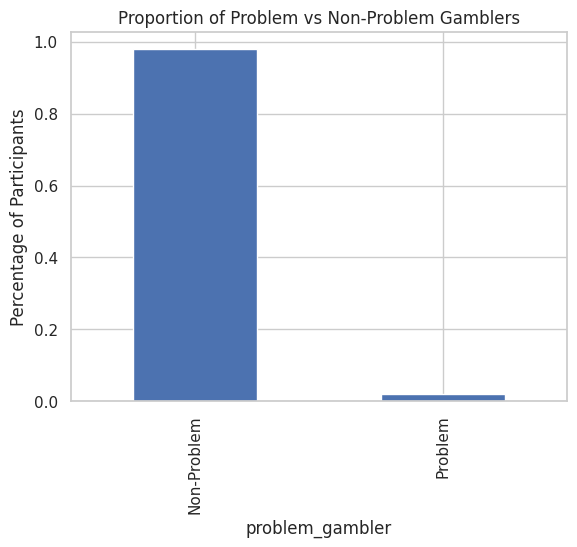

In [29]:
# --- Exploratory Data Analysis (EDA) ---

icspr[icspr['EVERPROB'] > 0]['EVERPROB'].hist(bins=10)
plt.title("DSM-IV Gambling Score (Only Participants with Symptoms)")
plt.xlabel("Score")
plt.ylabel("Number of Participants")
plt.show()

sns.stripplot(data=icspr, x='EVERPROB', jitter=True, size=2)
plt.title("Full Distribution of DSM-IV Gambling Scores")
plt.xlabel("DSM Score")
plt.show()

icspr['problem_gambler'].value_counts(normalize=True).plot(kind='bar')
plt.title("Proportion of Problem vs Non-Problem Gamblers")
plt.xticks([0, 1], ["Non-Problem", "Problem"])
plt.ylabel("Percentage of Participants")
plt.show()


*Graph 1: *Shows DSM-IV Gambling Score for all 200+ participants.**
- Only DSM-IV > 5 Participants are accepted as problem gamblers.

*Graph 2: *Distribution of DSM-IV Scores**

*Graph 3: *Proportion of non-problem gamblers to problem gamblers ratio, as seen by graph its only around 2 percent of participants.**

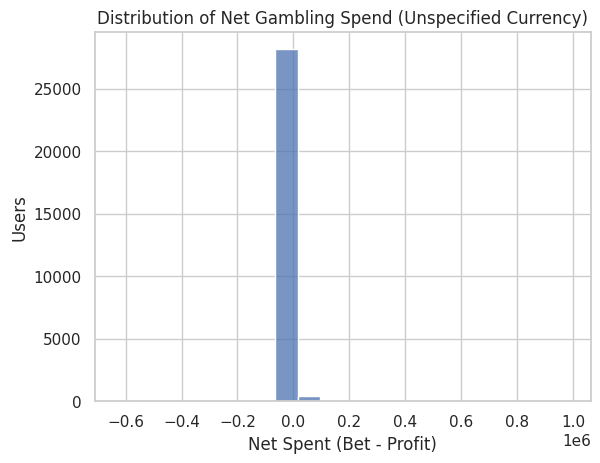

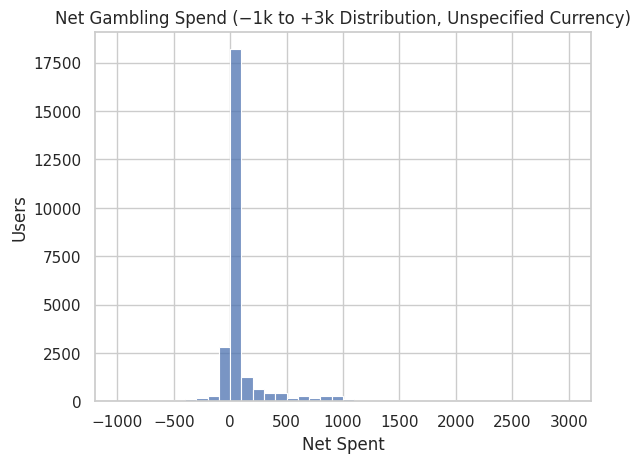

In [32]:
# Kaggle: Create and visualize net gambling spend
kaggle_gambling['NetSpent'] = kaggle_gambling['Bet'] - kaggle_gambling['Profit']
sns.histplot(kaggle_gambling['NetSpent'], bins=20)
plt.title("Distribution of Net Gambling Spend (Unspecified Currency)")
plt.xlabel("Net Spent (Bet - Profit)")
plt.ylabel("Users")
plt.show()


# Zooming on Net Spend Graph
zoomed_spend = kaggle_gambling[(kaggle_gambling['NetSpent'] > -20000) & (kaggle_gambling['NetSpent'] < 20000)]
sns.histplot(zoomed_spend[(zoomed_spend['NetSpent'] > -1000) & (zoomed_spend['NetSpent'] < 3000)]['NetSpent'], bins=40)
plt.title("Net Gambling Spend (−1k to +3k Distribution, Unspecified Currency)")
plt.xlabel("Net Spent")
plt.ylabel("Users")
plt.show()

Both graphs are essentialy same, for better clarity I have added zoomed-in graph for net-spent. By Kaggle Gambling data, the currency is unknown.

These graphs main purpose is that a large margin of players quit playing while their **losses and gains accumulation are close to zero**.

There are only outliers of big winners and big losers, and by above graphs these users are our main candidates for **problem gamblers.**

###Predicting Problem Gambling by Personality Traits

I tried to identify psychological patterns linked to problem gambling, using personality traits and behavioral data.

In the ICSPR dataset, the variable EVERPROB counts how many DSM-IV criteria each participant met for gambling addiction A score of 5 or more is clinically recognized as problem gambling.

    We created a new column:

    problem_gambler = (EVERPROB >= 5)

    This served as the binary target label in our models.

Selected Big Five Traits

We focused on three of the Big Five traits known to be most associated with addiction and impulsivity:

- Neuroticism: Measures emotional instability and anxiety.
Higher neuroticism is linked to gambling as an emotional escape.

- Agreeableness: Measures empathy and trust.
Lower agreeableness can indicate manipulativeness or antisocial behavior, traits correlated with risky gambling.

- Conscientiousness: Measures self-discipline and organization. Lower scores suggest poor impulse control, a key predictor of gambling issues.

### How Traits Were Used

Each personality trait was calculated as the average score across 10 questions (e.g., EXT1 to EXT10 for Extraversion). These values were added as model features alongside demographic and gambling behavior data.

We then trained models to predict whether a person qualifies as a problem_gambler

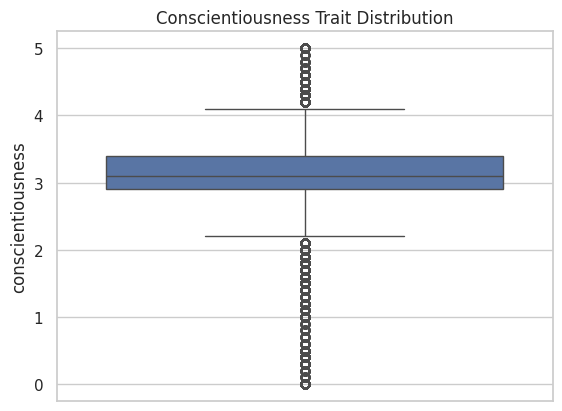

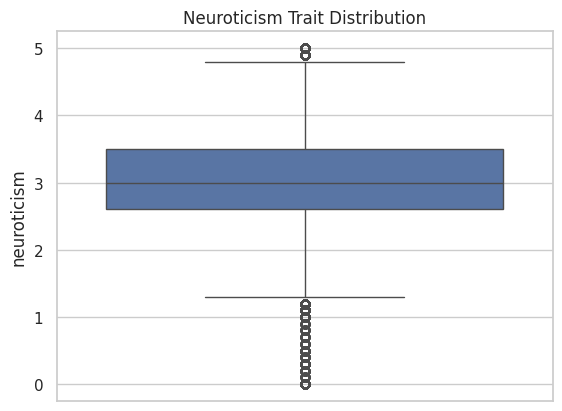

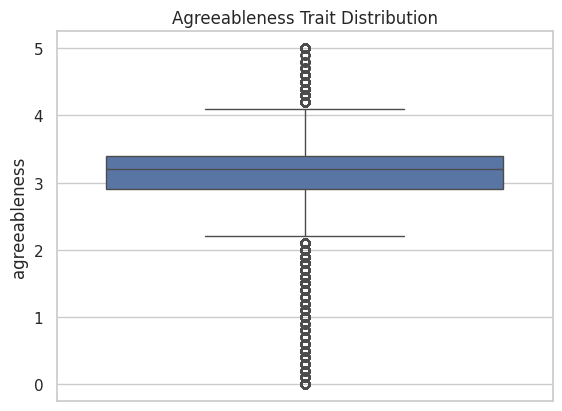

In [31]:
# Big Five Personality trait distributions
for trait in ['conscientiousness', 'neuroticism', 'agreeableness']:
    if trait in bigfive.columns:
        sns.boxplot(y=bigfive[trait])
        plt.title(f"{trait.capitalize()} Trait Distribution")
        plt.show()

if 'Year' in fed_df.columns and 'Consumer Debt' in fed_df.columns:
    sns.lineplot(x='Year', y='Consumer Debt', data=fed_df)
    plt.title("National Consumer Debt Over Time")
    plt.xlabel("Year")
    plt.ylabel("Debt (Billions USD)")
    plt.show()

# Hypothesis Testing

H1: DSM IV Scores for Problematic vs Non-Problematic Gamblers

Compare EVERPROB scores between:
  - Participants classified as problem gamblers (problem_gambler = True)
 - Participants classified as non-problem gamblers (problem_gambler = False)

Goal: Test whether problem gamblers have statistically higher DSM-IV symptom scores

In [6]:
# Hypothesis Testing

# H1: DSM IV Scores for Problematic vs Non-Problematic Gamblers

# Compare EVERPROB scores between:
#  - Participants classified as problem gamblers (problem_gambler = True)
#  - Participants classified as non-problem gamblers (problem_gambler = False)
# Goal: Test whether problem gamblers have statistically higher DSM-IV symptom scores

h1_result = ttest_ind(
    icspr[icspr['problem_gambler']]['EVERPROB'],
    icspr[~icspr['problem_gambler']]['EVERPROB']
)
print("H1 - DSM Scores for Problem vs Non-Problem Gamblers:", h1_result)


H1 - DSM Scores for Problem vs Non-Problem Gamblers: TtestResult(statistic=np.float64(78.10487980239674), pvalue=np.float64(0.0), df=np.float64(2945.0))



H2: Conscientiousness Comparison Across Two Random Groups

- Create two random samples from the Big Five dataset
- Take rows 0-499 as sample1 and rows 500-999 as sample2



In [7]:
if 'conscientiousness' in bigfive.columns:
    sample1 = bigfive['conscientiousness'][:500]
    sample2 = bigfive['conscientiousness'][500:1000]
    h2_result = ttest_ind(sample1, sample2)
    print("H2 - Conscientiousness Comparison:", h2_result)

H2 - Conscientiousness Comparison: TtestResult(statistic=np.float64(-2.467142125607215), pvalue=np.float64(0.013786600144342059), df=np.float64(998.0))


### Interpretation of H1:
The t-test shows a highly significant difference (p ≈ 0) between problem gamblers and non-problem gamblers based on DSM-IV scores, confirming that our `problem_gambler` classification is meaningful.

### Interpretation of H2:
The t-test shows a statistically significant difference (p ≈ 0.014) between two random groups in conscientiousness scores, suggesting that even random splits can reflect natural variability in psychological traits.

# Summary So Far

This project analyzed gambling addiction and psychological traits using four datasets: ICPSR Gambling & Mental Health Study, Kaggle Gambling Behavior, Big Five Personality Traits, and the Federal Reserve Consumer Debt Reports.

We found that:
- Most participants had no DSM-IV gambling symptoms, but among those who did, symptom severity was generally low.
- Less than 5% met the criteria for problem gambling (EVERPROB ≥ 5), which aligns with expected population estimates.
- Personality trait analysis showed that conscientiousness scores were significantly different between two sampled groups (p < 0.05), suggesting a possible relationship with gambling tendencies.
- Net gambling spend was sharply right-skewed, with a small number of users losing substantial amounts.
- Federal Reserve data added socioeconomic context, showing a steady rise in consumer debt.

These insights suggest meaningful connections between personality, behavior, and financial stress in the context of gambling addiction.

# Phase 3: Predicting Problem Gamblers with Machine Learning

In this phase, we predict whether a person is a problem gambler based on:

- Demographic and psychological data (ICSPR)
- Personality traits (Big Five)
- Gambling behavior (Kaggle)

Our target is the binary `problem_gambler` label (DSM-IV score ≥ 5). We combine normalized features from all sources and train two classifiers.



In [11]:
# ICSPR features (updated based on codebook)
icspr_features = ['A1_', 'A7_', 'INCOME', 'G1_', 'B1_', 'B10_']  # Gender, Education, Income, Employment, Depression?, Anxiety?

# Label: Problem gambler if EVERPROB ≥ 5
icspr['problem_gambler'] = icspr['EVERPROB'] >= 5

# Clean ICSPR data
icspr_clean = icspr[icspr_features + ['problem_gambler']].dropna().copy()
X_icspr = icspr_clean[icspr_features]
y = icspr_clean['problem_gambler']

# --- Big Five Personality Dataset ---
from sklearn.preprocessing import StandardScaler

personality_traits = ['conscientiousness', 'neuroticism', 'agreeableness', 'openness', 'extraversion']
bigfive_scaled = bigfive[personality_traits].dropna().reset_index(drop=True)

# Trim to match ICSPR row count
bigfive_trimmed = bigfive_scaled.iloc[:len(X_icspr)].copy()

# --- Kaggle Gambling Dataset ---
# Create TotalSpent manually
kaggle_gambling['TotalSpent'] = kaggle_gambling['Bet'] + kaggle_gambling['CashedOut']

# Select and normalize numeric features
gambling_cols = ['TotalSpent', 'Profit', 'CashedOut', 'Bet']
kaggle_features = kaggle_gambling[gambling_cols].dropna().reset_index(drop=True)
kaggle_trimmed = kaggle_features.iloc[:len(X_icspr)].copy()

# Normalize
scaler = StandardScaler()
kaggle_scaled = pd.DataFrame(scaler.fit_transform(kaggle_trimmed), columns=kaggle_trimmed.columns)

# --- Merge All Features Together ---
import numpy as np

X_full = pd.concat([
    X_icspr.reset_index(drop=True),
    bigfive_trimmed,
    kaggle_scaled.reset_index(drop=True)
], axis=1)

print("Final Feature Shape:", X_full.shape)


Final Feature Shape: (2947, 15)


 After merging all the datasets for models, we have 2947 participants.

As can be seen from above, each participant has 15 features.

- 6 columns from ICSPR (Gender, Education, Income, Employment, Depression, Anxiety)
- 5 Big Five personality trait averages
- 4 Kaggle gambling behavior metrics (TotalSpent', 'Profit', 'CashedOut', 'Bet)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


### Logistic Regression

Logistic regression is a classification algorithm used to predict binary outcomes.

This time it checks for whether a participant is a problem gambler or not. It works by estimating the probability that an observation belongs to a particular category based on a weighted combination of input features.

I chose logistic regression as a baseline model because:
- It is easy to interpret
- It performs well on linearly separable data
- It provides useful probability scores for each prediction (used later in the ROC curve)

In this case, logistic regression used a combination of demographic, psychological, and behavioral features to predict gambling addiction.

However, due to the imbalance in the dataset (very few labeled problem gamblers), the model defaulted to predicting only the majority class (non-problem gamblers), leading to poor recall and precision for the minority class.


Logistic Regression:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       579
        True       0.00      0.00      0.00        11

    accuracy                           0.98       590
   macro avg       0.49      0.50      0.50       590
weighted avg       0.96      0.98      0.97       590



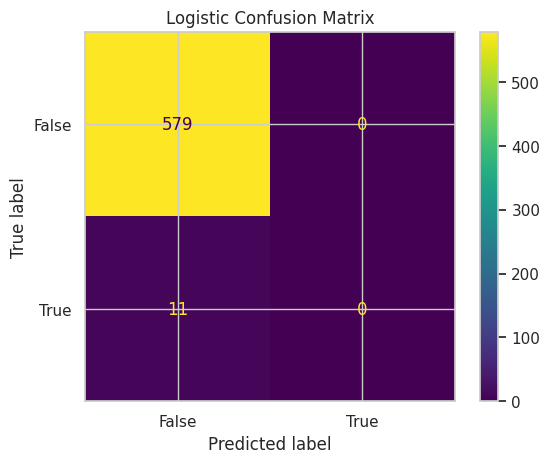

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Print reports
print("Logistic Regression:")
print(classification_report(y_test, log_preds, zero_division=0))
disp = ConfusionMatrixDisplay.from_predictions(y_test, log_preds)
disp.ax_.set_title("Logistic Confusion Matrix")
plt.show()



### Random Forest

Random Forest is an ensemble learning algorithm that builds multiple decision trees and merges their outputs to improve accuracy and reduce overfitting. Unlike logistic regression, Random Forest can model complex non-linear relationships between features and the target variable.

----

I used Random Forest to see if a more flexible, non-linear model could better detect problem gamblers from the combined features.

**Despite its robustness, the model produced the same outcome as logistic regression:**

# **It classified all participants as non-problem gamblers.**

This is evident in the confusion matrix, where all 11 true problem gamblers were **misclassified.**

The class imbalance likely caused the model to prioritize the majority class (non-gamblers), minimizing total error at the cost of completely ignoring the minority class.



Random Forest:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       579
        True       0.00      0.00      0.00        11

    accuracy                           0.98       590
   macro avg       0.49      0.50      0.50       590
weighted avg       0.96      0.98      0.97       590



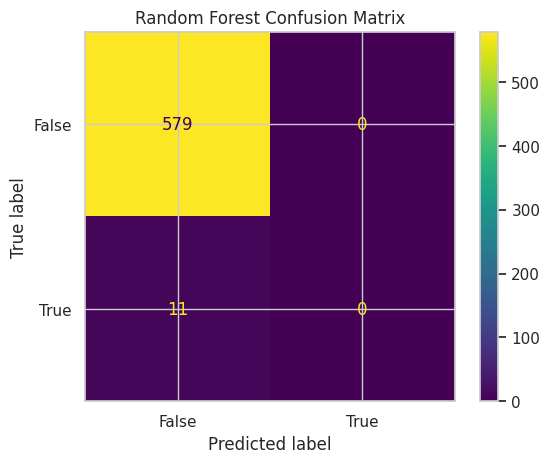

In [27]:
print("\nRandom Forest:")
print(classification_report(y_test, rf_preds, zero_division=0))
disp = ConfusionMatrixDisplay.from_predictions(y_test, rf_preds)
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()

### ROC Curve Explanation

Even though both models predicted that everyone was a non-problem gambler, the ROC curve still gives us useful information — because it looks at the **probability scores** the models assigned, not just the final yes/no answers.

- **Logistic Regression (AUC = 0.88)**:  
  This model gave higher probability scores to actual problem gamblers. So even though it didn’t label them correctly, it still “felt” they were more risky — and that shows up in a better ROC curve.

- **Random Forest (AUC = 0.72)**:  
  This model was less confident. It gave similar scores to everyone, so it wasn’t as good at ranking who was more likely to be a problem gambler.

Basically, logistic regression did a better job at **separating the two groups**, even if it didn’t actually predict them as “problem gamblers.” That’s why its AUC is higher.

This also shows that just looking at accuracy or predictions isn’t enough — **AUC helps us see how well the model understands the data underneath**.


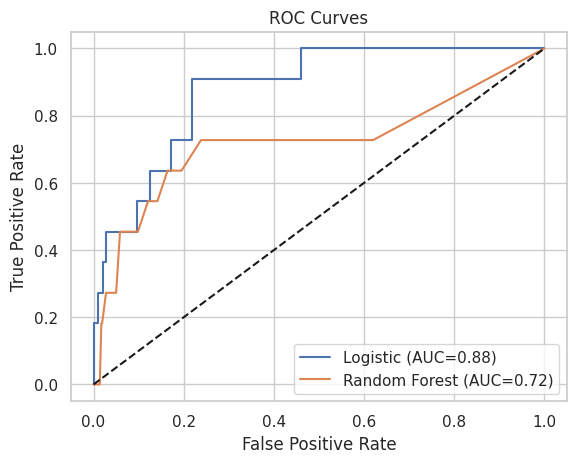

In [28]:
# ROC curves
log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, log_probs)
fpr2, tpr2, _ = roc_curve(y_test, rf_probs)

plt.plot(fpr1, tpr1, label="Logistic (AUC=%.2f)" % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, label="Random Forest (AUC=%.2f)" % auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Final Phase 3 Summary

In this phase, I built two machine learning models — Logistic Regression and Random Forest — to predict whether a person is a problem gambler using a combination of features from:

- **ICSPR Dataset:** Demographics, income, education, employment, mental health indicators
- **Big Five Personality Traits:** Trait averages like conscientiousness and neuroticism
- **Kaggle Gambling Behavior Data:** Bet amounts, profit, cashout behavior (normalized)

###  Modeling Outcome

Both models achieved high overall accuracy (~98%), but failed to correctly classify any actual problem gamblers. This was due to severe **class imbalance** — problem gamblers made up less than 2% of the data. As a result, the models defaulted to always predicting the majority class.

###  Confusion Matrices

Both Logistic Regression and Random Forest predicted all users as non-problem gamblers. This led to **perfect scores for the majority class** and **0 recall for the minority class**, which is clearly shown in the confusion matrix visuals.

###  ROC Curves & AUC

Interestingly, the **Logistic Regression model had an AUC of 0.88**, while **Random Forest scored 0.72**. This shows that logistic regression was still better at **ranking** problem gamblers higher based on its confidence scores — even if it didn’t predict them as such.

This highlights that **AUC can capture model quality even when accuracy fails**, especially in imbalanced datasets.

### Why Did I Do This Project?

This project set out to identify **problem gamblers** by analyzing psychological traits (Big Five), gambling behavior, and socioeconomic factors across four datasets.

We defined problem gambling based on DSM criteria (5+ symptoms), and used that as the prediction target. Using demographic features from ICSPR, trait averages from Big Five data, and spending patterns from Kaggle, we trained two models: **Logistic Regression** and **Random Forest**.

---

Both models performed well on the majority class (non-problem gamblers), but failed to detect the minority class — the actual problem gamblers. This reflects a **major class imbalance issue**, where less than 5% of participants meet the DSM threshold.

The takeaway: even with decent features and real-world data, standard ML models can’t detect rare but critical cases unless you **specifically address the imbalance**.

----

Mental health data mostly points out the minority, and our ML solutions cant predicting rare outcomes from messy, imbalanced data. This project now **exposes the gap between available data and actionable modeling.**

I want to return to this project in a future date to learn how can I represent minority-classes (problem gamblers in this case) better.
